## Deep Convolutional GAN's 
DCGAN consists of a CNN-based generator and a discriminator that satisfies certain
properties to ensure stable training.
Architecture guidelines for stable Deep Convolutional GANs:
* Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
* Use batchnorm in both the generator and the discriminator.
* Remove fully connected hidden layers for deeper architectures.
* Use ReLU activation in generator for all layers except for the output, which uses Tanh.
* Use LeakyReLU activation in the discriminator for all layers.

In [1]:
# resolving imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.datasets import ImageFolder
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import os
import numpy as np
import matplotlib.pyplot as plt


### Loading Dataset

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 2e-4 
batch_size = 128
image_size = 64
channels_img  = 3
z_dim = 100
epochs = 10
feat_disc = 64
features_e = 64
feat_gen = 64
device

device(type='cuda')

In [3]:
cwd = os.getcwd()
os.chdir(cwd)
print(os.listdir("../input"))

['celeba-dataset']


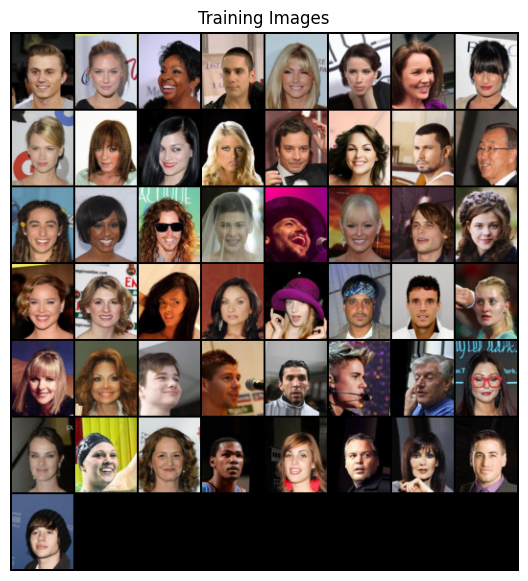

In [4]:
data_dir = '/kaggle/input/celeba-dataset/img_align_celeba'
# Define the data transforms
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Create the data loader
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)
real_batch = next(iter(data_loader))

# check few of the images
plt.figure(figsize=(7,7))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:49], padding=2, normalize=True).cpu(),(1,2,0)))

### Making ConvBlock & tConvBlock

In [5]:
# for encoder we will use LeakyRelU
def convblock(in_channels,out_channels,kernel_size=4,stride=2,padding=1):
    layers=[nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding)]
    layers.append(nn.BatchNorm2d(num_features=out_channels))
    layers.append(nn.LeakyReLU(0.25))
    return nn.Sequential(*layers)

# for decoder we will use normal ReLU
def tconvblock(in_channels,out_channels,kernel_size=4,stride=2,padding=1):
    layers=[nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride,padding)]
    layers.append(nn.BatchNorm2d(num_features=out_channels))
    layers.append(nn.ReLU())
    layers.append(nn.Dropout2d(0.25))
    return nn.Sequential(*layers)

### Encoder Model

In [6]:
class Encoder(nn.Module):
    
    def __init__(self, channels_img, features_e, z_dim):
        super(Encoder, self).__init__()
        
        self.encoder = nn.Sequential(
            # Input: channels_img x 64 x 64
            convblock(channels_img, features_e, kernel_size=4, stride=2, padding=1),  # Output: features_e x 32 x 32
            convblock(features_e, features_e*2, kernel_size=4, stride=2, padding=1),  # Output: features_e*2 x 16 x 16
            convblock(features_e*2, features_e*4, kernel_size=4, stride=2, padding=1),  # Output: features_e*4 x 8 x 8
            convblock(features_e*4, features_e*8, kernel_size=4, stride=2, padding=1),  # Output: features_e*8 x 4 x 4
            convblock(features_e*8, features_e*16, kernel_size=4, stride=2, padding=1),  # Output: features_e*16 x 2 x 2
            convblock(features_e*16, features_e*32, kernel_size=4, stride=2, padding=1),  # Output: features_e*32 x 1 x 1
        )
        
        # Fully connected layer to output z_dim-dimensional vector
        self.fc = nn.Linear(features_e*32, z_dim)
        
        
    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten the output tensor
        x = self.fc(x)
        return x

### Discriminator Model

In [7]:
class Discriminator(nn.Module):
    
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        
        self.disc = nn.Sequential(
            # Input: channels_img x 64 x 64
            convblock(channels_img, features_d, kernel_size=4, stride=2, padding=1),  # Output: features_d x 32 x 32
            convblock(features_d, features_d*2, kernel_size=4, stride=2, padding=1),  # Output: features_d*2 x 16 x 16
            convblock(features_d*2, features_d*4, kernel_size=4, stride=2, padding=1),  # Output: features_d*4 x 8 x 8
            convblock(features_d*4, features_d*8, kernel_size=4, stride=2, padding=1),  # Output: features_d*8 x 4 x 4
            nn.Conv2d(features_d*8, features_d*16, kernel_size=4, stride=2, padding=0),  # Output: features_d*16 x 1 x 1
            nn.Conv2d(features_d*16, 1, kernel_size=1, stride=1, padding=0),  # Output: 1x1x1
            nn.Flatten()  
        )
        
    def forward(self, x):
        return self.disc(x)

### Generator Model

In [8]:
class Generator(nn.Module):
    
    def __init__(self, z_dim, channels_img, features_g):
        super(Generator, self).__init__()
        
        self.net = nn.Sequential(
            # Input: z_dim x 1 x 1
            tconvblock(z_dim, features_g*8, kernel_size=4, stride=2, padding=0),  # Output: features_g*8 x 4 x 4
            tconvblock(features_g*8, features_g*4, kernel_size=4, stride=2, padding=1),  # Output: features_g*4 x 8 x 8
            tconvblock(features_g*4, features_g*2, kernel_size=4, stride=2, padding=1),  # Output: features_g*2 x 16 x 16
            tconvblock(features_g*2, features_g, kernel_size=4, stride=2, padding=1),  # Output: features_g x 32 x 32
            nn.ConvTranspose2d(features_g, channels_img, kernel_size=4, stride=2, padding=1),  # Output: channels_img x 64 x 64
            nn.Tanh()
        )
        
    def forward(self, x):
        x = x.view(x.shape[0], -1, 1, 1)
        return self.net(x)

### Training

In [9]:
device

device(type='cuda')

In [10]:
torch.cuda.device_count()

2

In [11]:
import torch.nn as nn

# Define the criterion
criterion = nn.BCELoss()

In [12]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [13]:
torch.cuda.empty_cache()

In [ ]:
# Directory to save checkpoints
checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Instantiate Generator, Encoder, and Discriminator
generator = Generator(z_dim, channels_img, feat_gen).to(device)
encoder = Encoder(channels_img, features_e, z_dim).to(device)
discriminator = Discriminator(channels_img, feat_disc).to(device)

# If multiple GPUs are available, use DataParallel to utilize all GPUs
if torch.cuda.device_count() > 1:
    generator = nn.DataParallel(generator)
    encoder = nn.DataParallel(encoder)
    discriminator = nn.DataParallel(discriminator)

# Define optimizers
gen_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
enc_optimizer = optim.Adam(encoder.parameters(), lr=0.0002, betas=(0.5, 0.999))
disc_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training loop
num_epochs = 10
checkpoint_freq = 100  # Save checkpoint every 100 batches
for epoch in range(num_epochs):
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    for batch_idx, (real_images, _) in enumerate(data_loader):
        real_images = real_images.to(device)
        
        # Train Discriminator
        disc_optimizer.zero_grad()
        
        # Forward pass real images through the encoder
        latent_vectors = encoder(real_images)
        
        # Generate fake images with the generator using the latent vectors
        fake_images = generator(latent_vectors)
        
        # Calculate adversarial loss for discriminator
        real_labels = torch.ones(real_images.size(0), 1).to(device)
        fake_labels = torch.zeros(real_images.size(0), 1).to(device)
        disc_real_output = discriminator(real_images)
        disc_fake_output = discriminator(fake_images.detach())
        disc_real_loss = criterion(disc_real_output, real_labels)
        disc_fake_loss = criterion(disc_fake_output, fake_labels)
        disc_loss = disc_real_loss + disc_fake_loss
        
        # Backpropagation
        disc_loss.backward()
        disc_optimizer.step()
        
        # Train Generator and Encoder
        gen_optimizer.zero_grad()
        enc_optimizer.zero_grad()
        
        # Forward pass real images through the encoder
        latent_vectors = encoder(real_images)
        
        # Generate fake images with the generator using the latent vectors
        fake_images = generator(latent_vectors)
        
        # Calculate adversarial loss for generator
        disc_fake_output = discriminator(fake_images)
        gen_loss = criterion(disc_fake_output, real_labels)
        
        # Calculate reconstruction loss for encoder
        reconstructed_latent_vectors = encoder(fake_images)
        enc_loss = criterion(reconstructed_latent_vectors, latent_vectors)
        
        # Total loss
        total_loss = gen_loss + enc_loss
        
        # Backpropagation
        total_loss.backward()
        gen_optimizer.step()
        enc_optimizer.step()
        
        # Print batch information if needed
        if batch_idx % print_freq == 0:
            print(f"Batch [{batch_idx}/{len(data_loader)}]: Gen Loss {gen_loss.item():.4f}, Enc Loss {enc_loss.item():.4f}, Disc Loss {disc_loss.item():.4f}")

        # Save checkpoint
        if batch_idx % checkpoint_freq == 0:
            # Save generator, encoder, and discriminator states
            torch.save(generator.state_dict(), os.path.join(checkpoint_dir, f"generator_epoch{epoch}_batch{batch_idx}.pt"))
            torch.save(encoder.state_dict(), os.path.join(checkpoint_dir, f"encoder_epoch{epoch}_batch{batch_idx}.pt"))
            torch.save(discriminator.state_dict(), os.path.join(checkpoint_dir, f"discriminator_epoch{epoch}_batch{batch_idx}.pt"))
            # Save optimizer states
            torch.save(gen_optimizer.state_dict(), os.path.join(checkpoint_dir, f"gen_optimizer_epoch{epoch}_batch{batch_idx}.pt"))
            torch.save(enc_optimizer.state_dict(), os.path.join(checkpoint_dir, f"enc_optimizer_epoch{epoch}_batch{batch_idx}.pt"))
            torch.save(disc_optimizer.state_dict(), os.path.join(checkpoint_dir, f"disc_optimizer_epoch{epoch}_batch{batch_idx}.pt"))

    # Optionally, print epoch summary
    print(f"Epoch [{epoch+1}/{num_epochs}]: Gen Loss {gen_loss.item():.4f}, Enc Loss {enc_loss.item():.4f}, Disc Loss {disc_loss.item():.4f}")


Epoch [1/10]
